In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify
import datetime as dt

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found


In [8]:
# Save references to each table
station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
#Finding columns and datatype
from sqlalchemy import inspect,func
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=year_back).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})
# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)

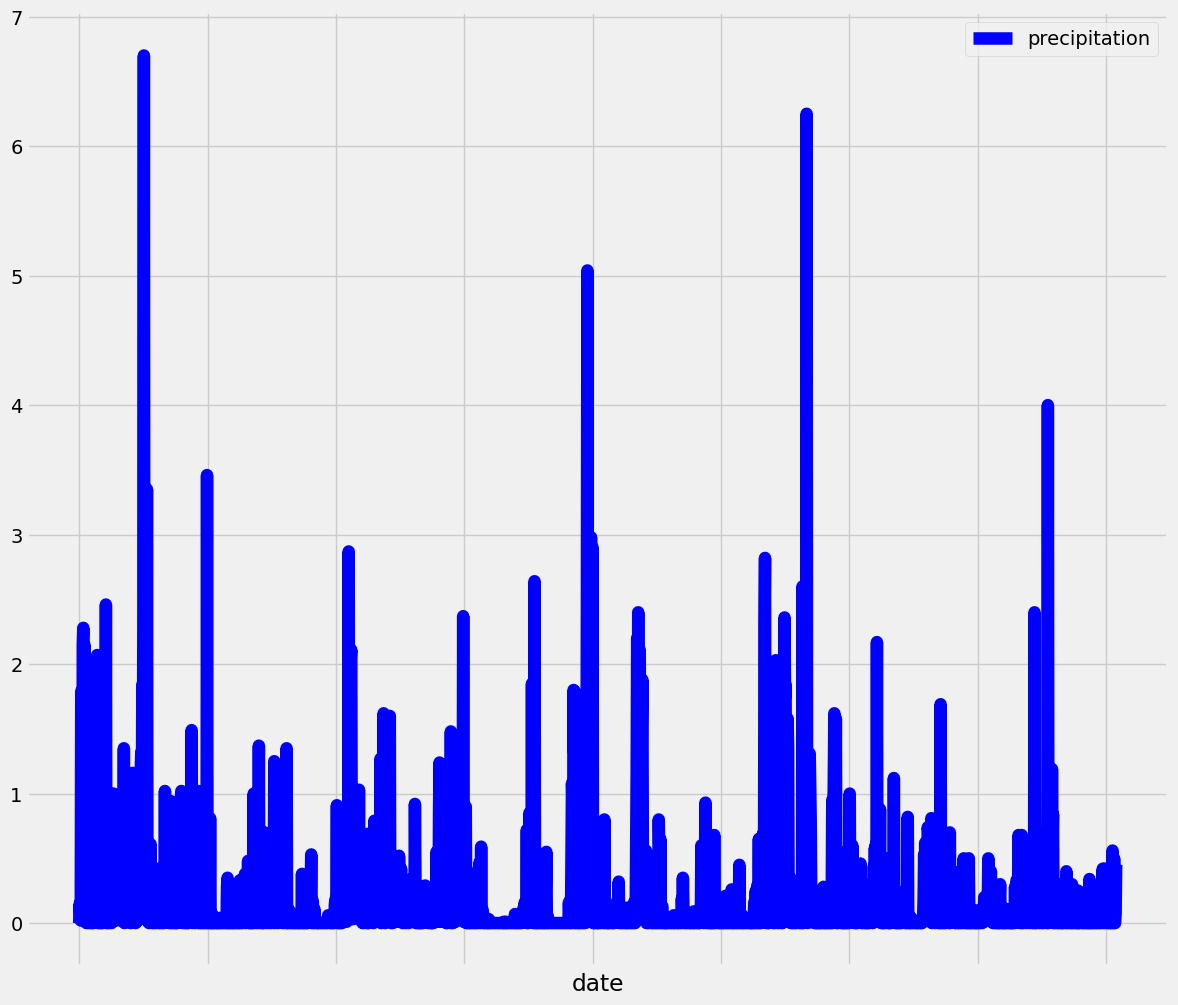

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
ax=df_results.plot(color='b',figsize=(12,10),legend=True,linewidth=9.0,grid=True)
#Removing xticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("date")
plt.show()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_results.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
#Finding columns and datatype
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Station Analysis

In [32]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(func.count(station.id)).all()
station_count

[(9,)]

In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_Measurment_join=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_Measurment_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_Measurment_join[0][0]).all()
results_temp

[(54.0, 85.0, 71.66378066378067)]

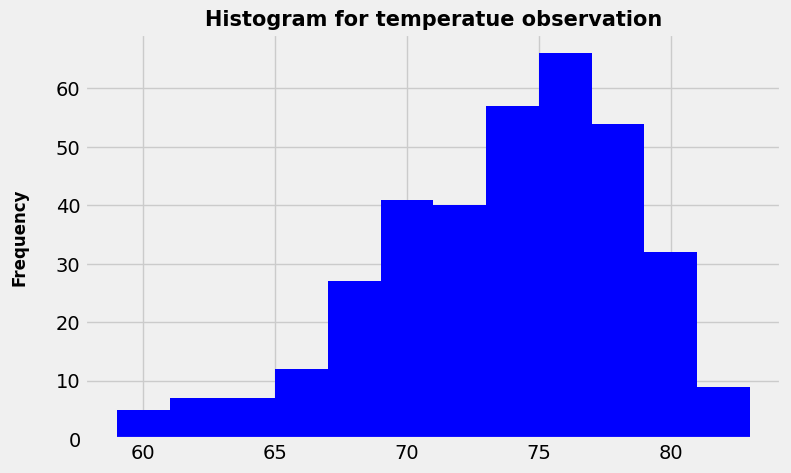

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).\
             filter(Measurement.station==station_Measurment_join[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(Measurement.tobs).\
             filter(Measurement.station==station_Measurment_join[0][0]).\
             filter(Measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)


#Plotting Histogram
hist = df_results['tobs'].hist(bins=12,figsize=(8,5), color='b', zorder=2)

# Remove title
hist.set_title("Histogram for temperatue observation",weight='bold', size=15)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

plt.show()

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year=year_back.year
start_date=str(prev_year)+'-02-28'
end_date=str(prev_year)+'-03-05'
Temp_holiday=calc_temps(start_date, end_date)
Temp_holiday_avg=Temp_holiday[0][1]
Temp_holiday_error=Temp_holiday[0][2]-Temp_holiday[0][0]

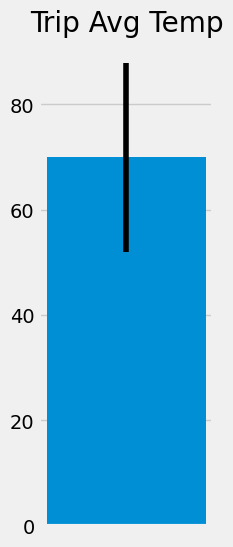

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(2,6))
plt.bar(1,Temp_holiday[0][1],yerr=Temp_holiday_error)
#Removing xticks
plt.xticks([])
plt.title("Trip Avg Temp")
plt.show()

In [46]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[station.station, station.name, station.latitude, station.longitude, station.elevation]
station_measurment_join=session.query(*sel,func.sum(Measurement.prcp)).\
                       group_by(measurement.station).\
                       order_by(measurement.station ).\
                       filter(measurement.date>=start_date).\
                       filter(measurement.date<=end_date).\
                       filter(measurement.station==station.station).all()
                        
station_Measurment_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

# Close Session

In [36]:
# Close Session
session.close()